## Statistical Analysis of LISST sediment GSD data

My dataset is a data table with the grain size distributions from different fine sediment traps (baskets) at the location at a hyporheic sensor probe in different locations in a river. There are 7 hyporheic sensors (T0, T25, T4, T5, T6, T7 and T8) and four baskets at each probe (A, B, C and D). There are some sensors that do not have all four baskets since some were washed away after the sampling period (Spring of 2023). 

The sediment accumulated in each of these traps was processed using Laser In-Situ Scattering and Transmissometry (LISST) using the LISST-Portable|XR from Sequoia Scientific to obtain the grain size distribution (GSD) of each of these samples. 

We want to know if whether the GSD of the basket samples in each hyporheic sensor probe (e.g. T3) are significantly different from eachother (T3A, T3B, T3C and T3D). For this, I want to attempt to do a non-parametric Kruskal Wallis test to see if this assumption is true or not. This is what I am trying to do throughout this notebook:

In [1]:
# we first import all the libraries we will need
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

# list all CSV files in the current folder
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

# loop through each CSV file and read it into a DataFrame and create variables
for csv_file in csv_files:
    file_name = os.path.splitext(csv_file)[0]  # Get the file name without the extension
    # create a variable with the file name and store the DataFrame
    exec(f"{file_name} = pd.read_csv('{csv_file}')")

After this, we should have four main variables: LISST_SP2023, LISST_volconc, LISST_cumconc and LISST_percentiles. 
- LISST_2023: this file is the raw measured data from the LISST-portable XR of each run that I did for a sample
- LISST_volconc: this file is the corresponding concentrations (out of a total) that corresponds to a certain grain size (by size bins, not individual counts)
- LISST_cumconc: this file is the cumulative percentages each of the concentrations from LISST_volconc correspond to. 
- LISST_percentiles: the percentiles extracted from the LISST-portable XR stats from the raw data

In [2]:
LISST_volconc # the size is in MICRONS (um)

,Size (um),T0C,T0D,T25A,T25B,T25C,T25D,T4A,T4B,T4C,...,T5D,T6A,T6B,T6C,T6D,T7A,T7C,T7D,T8A,T8B
0,0.37,0.11,0.15,0.17,0.18,0.19,0.19,0.27,0.19,0.21,...,0.18,0.25,0.13,0.31,0.260,0.14,0.13,0.23,0.17,0.10
1,0.44,0.10,0.15,0.17,0.19,0.19,0.19,0.27,0.19,0.21,...,0.18,0.24,0.13,0.30,0.260,0.14,0.13,0.23,0.17,0.10
2,0.52,0.10,0.15,0.17,0.19,0.19,0.19,0.27,0.19,0.21,...,0.18,0.22,0.13,0.28,0.250,0.14,0.13,0.23,0.17,0.10
3,0.61,0.10,0.15,0.17,0.20,0.19,0.19,0.27,0.18,0.21,...,0.18,0.20,0.12,0.26,0.240,0.14,0.13,0.24,0.17,0.10
4,0.72,0.10,0.15,0.17,0.21,0.19,0.20,0.27,0.18,0.21,...,0.18,0.18,0.12,0.25,0.230,0.14,0.12,0.25,0.17,0.10
5,0.85,0.11,0.16,0.18,0.23,0.21,0.22,0.29,0.19,0.23,...,0.20,0.19,0.13,0.26,0.240,0.16,0.13,0.27,0.19,0.11
6,1.01,0.14,0.21,0.23,0.29,0.26,0.27,0.36,0.24,0.29,...,0.25,0.25,0.16,0.32,0.300,0.20,0.16,0.34,0.24,0.14
7,1.19,0.20,0.30,0.33,0.41,0.37,0.39,0.51,0.37,0.42,...,0.36,0.38,0.23,0.45,0.420,0.28,0.23,0.48,0.35,0.20
8,1.40,0.29,0.42,0.46,0.59,0.51,0.54,0.73,0.57,0.60,...,0.51,0.55,0.32,0.62,0.580,0.39,0.32,0.69,0.49,0.28
9,1.65,0.35,0.51,0.56,0.72,0.62,0.65,0.90,0.72,0.74,...,0.63,0.67,0.38,0.73,0.690,0.47,0.38,0.85,0.61,0.33


In [3]:
LISST_cumconc

,Size (um),T0C,T0D,T25A,T25B,T25C,T25D,T4A,T4B,T4C,...,T5D,T6A,T6B,T6C,T6D,T7A,T7C,T7D,T8A,T8B
0,0.37,0.07,0.07,0.06,0.06,0.07,0.08,0.08,0.06,0.07,...,0.08,0.10,0.07,0.09,0.09,0.08,0.08,0.07,0.07,0.08
1,0.44,0.14,0.14,0.12,0.13,0.13,0.16,0.15,0.12,0.15,...,0.17,0.18,0.14,0.17,0.17,0.16,0.16,0.14,0.15,0.16
2,0.52,0.20,0.22,0.18,0.19,0.20,0.24,0.23,0.18,0.22,...,0.25,0.27,0.21,0.25,0.25,0.24,0.24,0.21,0.22,0.24
3,0.61,0.27,0.29,0.24,0.26,0.26,0.32,0.30,0.24,0.30,...,0.33,0.34,0.28,0.32,0.33,0.32,0.32,0.29,0.30,0.32
4,0.72,0.34,0.36,0.30,0.33,0.33,0.40,0.38,0.30,0.37,...,0.42,0.41,0.34,0.39,0.41,0.40,0.40,0.36,0.37,0.40
5,0.85,0.41,0.44,0.37,0.40,0.40,0.49,0.46,0.36,0.46,...,0.51,0.48,0.41,0.46,0.49,0.48,0.48,0.45,0.46,0.48
6,1.01,0.50,0.54,0.45,0.50,0.49,0.61,0.56,0.44,0.56,...,0.62,0.58,0.50,0.55,0.59,0.59,0.58,0.55,0.56,0.60
7,1.19,0.64,0.69,0.57,0.64,0.62,0.77,0.70,0.56,0.71,...,0.79,0.72,0.63,0.68,0.73,0.75,0.72,0.70,0.72,0.75
8,1.40,0.83,0.90,0.73,0.84,0.79,0.99,0.91,0.74,0.93,...,1.03,0.93,0.80,0.85,0.92,0.97,0.91,0.92,0.93,0.97
9,1.65,1.06,1.15,0.94,1.08,1.01,1.27,1.16,0.97,1.20,...,1.32,1.17,1.01,1.06,1.15,1.24,1.15,1.18,1.20,1.24


For the initial analysis, we will only be looking at data from T6 and then we will replicate this procedure for all other probes. 

Since the Kruskal wallis is a non-parametric test, we need to confirm the non-normality of the samples. 

We will first check visually and will later confirm this with a Kolmogorov-Smirnov test.

### Histogram: LISST default bins

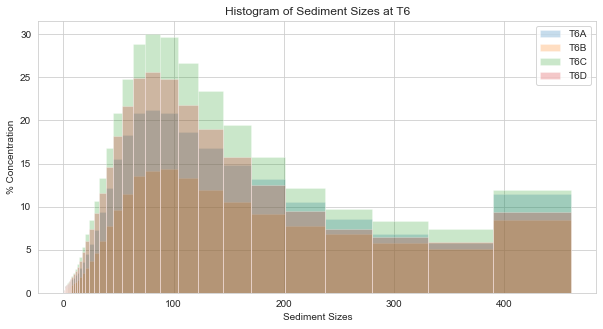

In [5]:
df = LISST_volconc[['T6A', 'T6B', 'T6C', 'T6D']]# the df to be tested for normality
sizes = LISST_volconc['Size (um)'] # the sizes of the sediment

# plotting the histogram
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df['T6A'], bins=sizes, alpha=0.25, label='T6A')
plt.hist(sizes, weights=df['T6B'], bins=sizes, alpha=0.25, label='T6B')
plt.hist(sizes, weights=df['T6C'], bins=sizes, alpha=0.25, label='T6C')
plt.hist(sizes, weights=df['T6D'], bins=sizes, alpha=0.25, label='T6D')
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes at T6')
plt.legend()
plt.show()

### Histogram: equally spaced bins

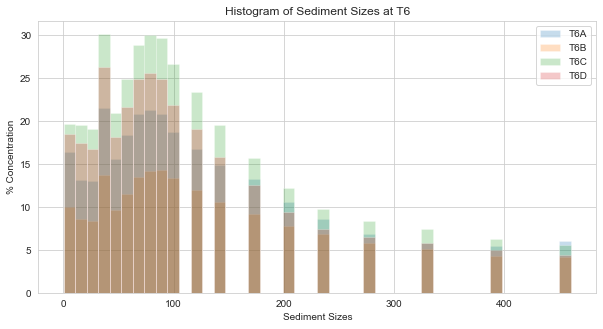

In [6]:
# plotting the histogram
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df['T6A'], bins=len(sizes), alpha=0.25, label='T6A')
plt.hist(sizes, weights=df['T6B'], bins=len(sizes), alpha=0.25, label='T6B')
plt.hist(sizes, weights=df['T6C'], bins=len(sizes), alpha=0.25, label='T6C')
plt.hist(sizes, weights=df['T6D'], bins=len(sizes), alpha=0.25, label='T6D')
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes at T6')
plt.legend()
plt.show()

It shows these spaces because there is no data that fell into the bins created

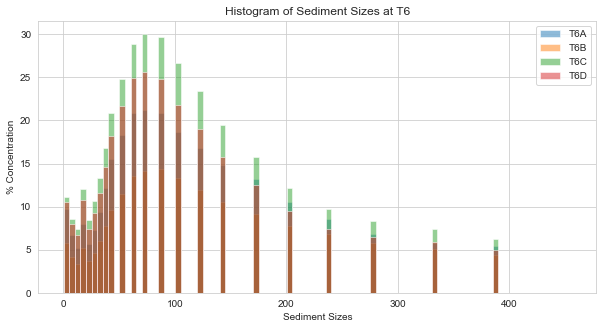

In [7]:
bins = np.arange(min(sizes), max(sizes), 5)  # custom bins (start, stop, step)

# plotting the histogram
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df['T6A'], bins=bins, alpha=0.5, label='T6A')
plt.hist(sizes, weights=df['T6B'], bins=bins, alpha=0.5, label='T6B')
plt.hist(sizes, weights=df['T6C'], bins=bins, alpha=0.5, label='T6C')
plt.hist(sizes, weights=df['T6D'], bins=bins, alpha=0.5, label='T6D')
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes at T6')
plt.legend()
plt.show()

We can see that these plots do not resemble a normal distribution, but to double check we will plot a Q-Q plot and applying the Kolmogorov-Smirnov test.

### Q-Q plot

We will first generate a table of all the percentiles of the distribution for all the basket samples (we will still only be looking at T6 though). We create this to have a higher resolution of the percentiles and not just by 10% intervals like we have in the raw data file 

In [8]:
# getting percentiles
percentiles = list(range(5, 100, 1))
# setting the sizes as the index
LISST_cumconc.set_index("Size (um)", inplace=True)

# interpolate the data to calculate percentiles
percentile_LISST = pd.DataFrame() # empty df
percentile_LISST['Percentiles'] = percentiles # changing the column name
percentile_LISST.set_index("Percentiles", inplace=True) # make it the index

for column_name in LISST_cumconc.columns: 
    interp = np.interp(percentiles, LISST_cumconc[column_name], LISST_cumconc.index)
    percentile_LISST[column_name] = interp # this adds the column name and results to the new df 

T6_percentiles = percentile_LISST[['T6A', 'T6B', 'T6C', 'T6D']]
T6_percentiles

,T6A,T6B,T6C,T6D
Percentiles,,,,
5,7.890000,9.133380,9.183684,8.110845
6,9.939600,11.327143,11.210000,9.968571
7,12.029091,13.475392,13.125726,11.826970
8,14.076698,15.540635,14.929189,13.590000
9,16.037405,17.523208,16.658919,15.263567
...,...,...,...,...
95,313.787465,323.942174,289.834928,281.389742
96,338.729655,346.525378,314.197246,307.384588
97,368.049852,371.533782,341.680000,334.512195


In [10]:
# export the percentile df to a csv
percentile_LISST.to_csv('actual_percentiles.csv')

Now, we will save only the T6 columns, where the data of each column is the interpolated percentiles of the sediment sizes. 

In [6]:
# For our Q-Q plot we must transform these into quantile data
T6_quantiles = T6_percentiles.copy()
T6_quantiles.index = T6_percentiles.index / 100
T6_quantiles

,T6A,T6B,T6C,T6D
Percentiles,,,,
0.05,7.890000,9.133380,9.183684,8.110845
0.06,9.939600,11.327143,11.210000,9.968571
0.07,12.029091,13.475392,13.125726,11.826970
0.08,14.076698,15.540635,14.929189,13.590000
0.09,16.037405,17.523208,16.658919,15.263567
...,...,...,...,...
0.95,313.787465,323.942174,289.834928,281.389742
0.96,338.729655,346.525378,314.197246,307.384588
0.97,368.049852,371.533782,341.680000,334.512195


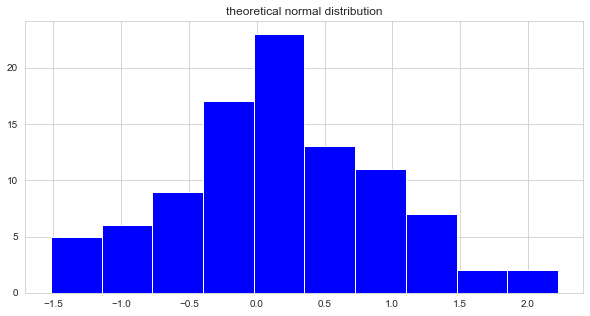

In [50]:
quantiles = T6_quantiles.index.values
sample_sizes = T6_quantiles['T6A'].values

# calculate the theoretical quantiles for a normal distribution
theoretical_quantiles = np.percentile(np.random.normal(size=(len(quantiles), 1)), quantiles*100) 

# plotting the histogram of the normal distribution
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(theoretical_quantiles.flatten(), color='blue')  # flatten the array
plt.title('theoretical normal distribution')
plt.show()

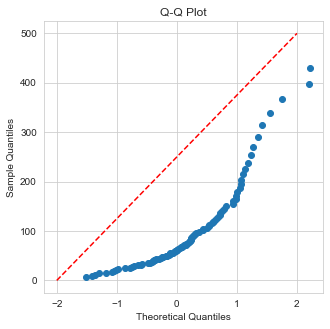

In [56]:

# Plot the Q-Q plot
plt.figure(figsize=(5, 5))
plt.scatter(theoretical_quantiles, np.sort(sample_sizes.flatten()))
plt.plot([-2, 2], [0, 500], color='red', linestyle='--')
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

This is a very unusual Q-Q plot and am not sure why it looks like this. ***(Ask statistics advisors)***

### KS test for normality

In [62]:
# retrieving the cumulative distribution
cum_dist = LISST_cumconc['T6A'].values
sizes = LISST_cumconc.index.values
cum_dist # this is the cumulative percentages of the data

array([  0.1 ,   0.18,   0.27,   0.34,   0.41,   0.48,   0.58,   0.72,
         0.93,   1.17,   1.46,   1.77,   2.1 ,   2.44,   2.8 ,   3.19,
         3.64,   4.15,   4.72,   5.38,   6.13,   7.01,   8.07,   9.38,
        11.05,  13.17,  15.91,  19.43,  23.96,  29.77,  36.63,  44.4 ,
        52.35,  60.14,  67.11,  73.38,  78.94,  83.89,  87.82,  91.01,
        93.55,  95.72,  97.75, 100.  ])

In [95]:
# generate an array of x values
x = np.linspace(-5, 5, 100)
# calculate the CDF for these x values
normal_cdf = sp.stats.norm.cdf(x, loc=0, scale=1) * 100
normal_cdf


array([2.86651572e-05, 4.81652980e-05, 8.01369697e-05, 1.32024804e-04,
       2.15381086e-04, 3.47932307e-04, 5.56574305e-04, 8.81655865e-04,
       1.38302263e-03, 2.14842775e-03, 3.30507197e-03, 5.03521029e-03,
       7.59694692e-03, 1.13515215e-02, 1.67985497e-02, 2.46207894e-02,
       3.57400327e-02, 5.13856234e-02, 7.31768322e-02, 1.03219832e-01,
       1.44219270e-01, 1.99603373e-01, 2.73660179e-01, 3.71680801e-01,
       5.00103726e-01, 6.66652060e-01, 8.80453516e-01, 1.15213100e+00,
       1.49385013e+00, 1.91930895e+00, 2.44365552e+00, 3.08331960e+00,
       3.85574780e+00, 4.77903523e+00, 5.87145199e+00, 7.15086990e+00,
       8.63410207e+00, 1.03361763e+01, 1.22695707e+01, 1.44434484e+01,
       1.68629302e+01, 1.95284521e+01, 2.24352499e+01, 2.55730119e+01,
       2.89257361e+01, 3.24718142e+01, 3.61843565e+01, 4.00317549e+01,
       4.39784680e+01, 4.79859962e+01, 5.20140038e+01, 5.60215320e+01,
       5.99682451e+01, 6.38156435e+01, 6.75281858e+01, 7.10742639e+01,
      

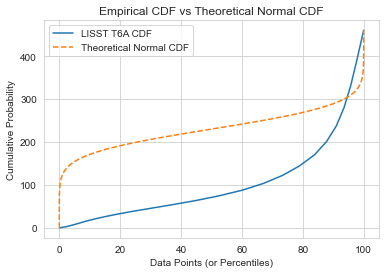

In [98]:
# plot the empirical CDF and the theoretical CDF
plt.plot(cum_dist, sizes, label='LISST T6A CDF')
plt.plot(normal_cdf, np.linspace(0,np.max(sizes), len(normal_cdf)), label='Theoretical Normal CDF', linestyle='--')
plt.legend()
plt.title('Empirical CDF vs Theoretical Normal CDF')
plt.xlabel('Data Points (or Percentiles)')
plt.ylabel('Cumulative Probability')
plt.show()

In [99]:
# Perform the Kolmogorov-Smirnov test
ks_statistic, ks_p_value = sp.stats.kstest(cum_dist, 'norm')

# Output the test results
print(f'Kolmogorov-Smirnov Statistic: {ks_statistic}')
print(f'P-value: {ks_p_value}')

# Check the p-value to determine whether to reject the null hypothesis
alpha = 0.05
if ks_p_value < alpha:
    print('Reject the null hypothesis. The data is not consistent with a normal distribution.')
else:
    print('Fail to reject the null hypothesis. The data appears to be consistent with a normal distribution.')

Kolmogorov-Smirnov Statistic: 0.7116364296371288
P-value: 5.216705368829974e-23
Reject the null hypothesis. The data is not consistent with a normal distribution.


From all those tests above, it looks like the data is not NORMALLY distributes, so we are in the clear to go forward with the KW test!

# Kruskal-Wallis test

In [13]:
# Perform Kruskal-Wallis test
stat, p_value = sp.stats.kruskal(LISST_volconc['T6A'], LISST_volconc['T6B'], LISST_volconc['T6C'], LISST_volconc['T6D']) 

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value}")

Kruskal-Wallis Statistic: 4.759328359329031
P-value: 0.1902927235692039


p > 0.10:
The result is not statistically significant, and there is insufficient evidence to reject the null hypothesis at the chosen significance level.

### Issue: this function assumes that I am inputing the WHOLE sample in and not just the binned data. I am stuck in this part, since I do not know how to interpret the "ranking of samples" in a kruskal-wallis analysis for binned data. 

### Is there any other way to do this? I am also open to other ways of finding out if the samples are significantly different from eachother or not :)